In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image 
from os import system
import matplotlib.pyplot as plt
plt.figure(figsize=(50,100))
sns.set(color_codes=True)
%matplotlib inline

In [2]:
bank = pd.DataFrame(pd.read_excel('Credit Card Customer Data.xlsx'))
bank.sample(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
161,162,78473,8000,3,2,5,5
426,427,93496,71000,7,2,0,2
513,514,43000,40000,5,3,1,4
552,553,80942,65000,7,3,2,1
638,639,17538,153000,8,1,7,1
334,335,41159,8000,7,4,2,0
326,327,22824,6000,4,4,2,3
657,658,53834,145000,8,1,9,1
72,73,27120,11000,3,1,2,6
235,236,83290,13000,7,4,0,0


1. The data has two identifiersi.e. first two columns. Except for Avg Credit limit which has a large variance, the other variables have a small range. These variable define the type of relationship with the customer i.e. Total Credit cards issued, visit online, calls and physical visits

In [3]:
print(bank.shape)
print(bank.info())
print(bank.nunique())
bank.describe()

(660, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB
None
Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


The data seems normal. The credit limit is more high range but the other variables are in small range. The data has a slight skew in the variable. Credit limit has high Std Dev i.e. variation.

In [4]:
bank.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

No null values. For clustering, we will need to drop the identifier columns

In [5]:
bank2=bank.drop(columns=['Sl_No','Customer Key'],axis=1)

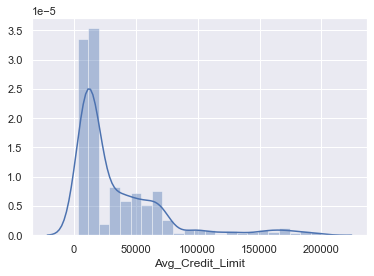

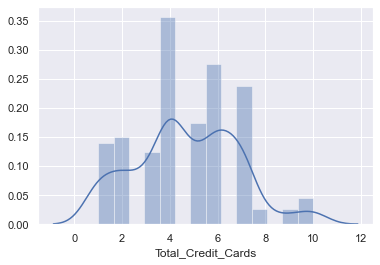

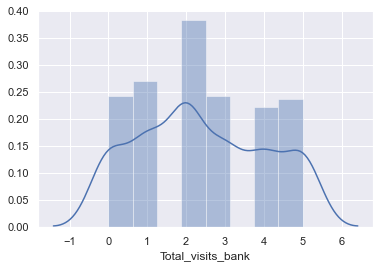

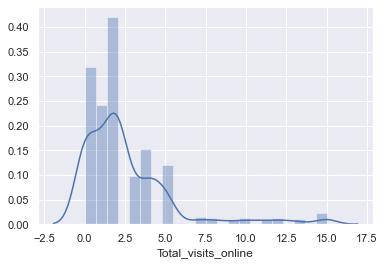

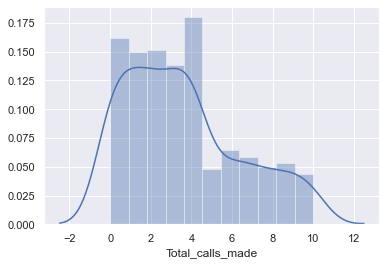

In [6]:
#univariate analyis
for i in ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']:
    sns.distplot(bank2[i])
    plt.show()

Av. Credit Limits distribution shows a mix of Gaussian and so does total calls made and online visits.Bank visits and credit cards also show imperfect normal distributions

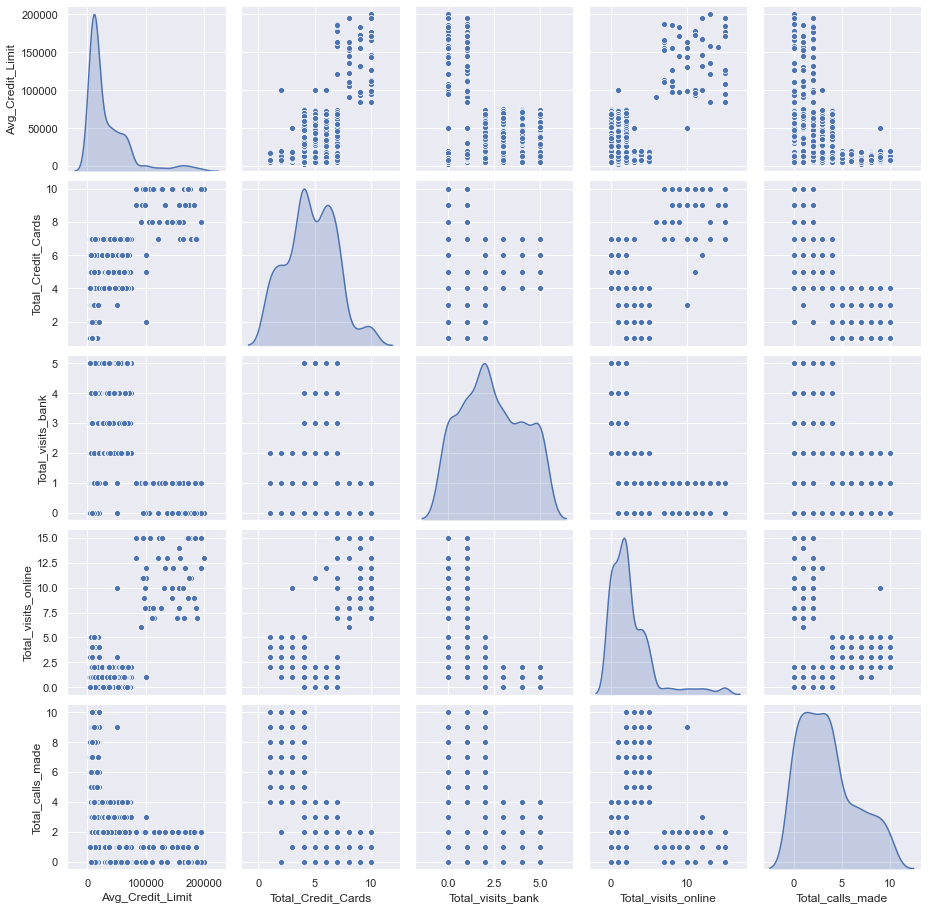

In [7]:
sns.pairplot(data=bank2,diag_kind='kde');

Average credit limit and total credit cards is coorelated but thats natural. The number of calls made are effective at first but loses value quickly, or the customers who engage in large number of credit cards are early respondent cluster.

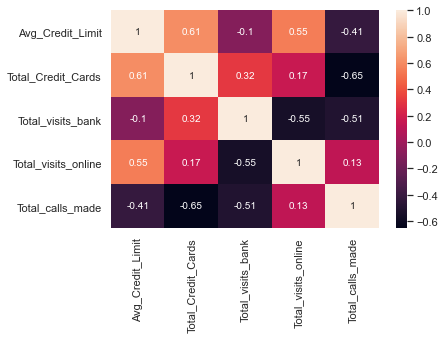

In [8]:
corr = bank2.corr()
sns.heatmap(corr,annot=True);

Full data shows credit limit and credit cards have a negative coorelation with calls made and positive with online and physical visits. However, this relationship might be due segments of customers and their behaviours. Some customers segments may respond highly to calls or early to calls and other might respond later. We need to see how these relationship hold in indivdual segments

In [9]:
#Normalizing a copy Analytics base table for k-means clustering
from scipy.stats import zscore

bank2_z = bank2.apply(zscore)

Text(0, 0.5, 'Average Distortion')

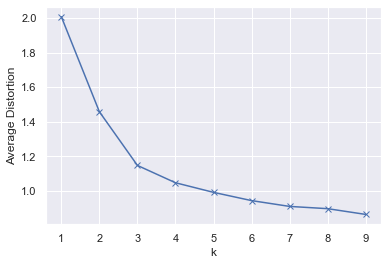

In [10]:
#using elbow method to discover the ideal number of clusters
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
clusters = range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(bank2_z)
    prediction=model.predict(bank2_z)
    meanDistortions.append(sum(np.min(cdist(bank2_z,model.cluster_centers_,'euclidean'),axis=1))/bank2_z.shape[0])
    
plt.plot(clusters,meanDistortions,'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')


3 clusters seem ideal from elbow above

In [11]:
#Actual clustering on the data
kmeans = KMeans(n_clusters=3)
kmeans.fit(bank2_z)

KMeans(n_clusters=3)

In [12]:
#understanding the type of customers in each cluster through understanding their centroids
centroids = kmeans.cluster_centers_
centroids_df=pd.DataFrame(centroids,columns=list(bank2_z))
centroids_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,2.831764,1.862226,-1.105763,2.827319,-0.874330
1,-0.595796,-1.059623,-0.901518,0.322997,1.148109
2,-0.021062,0.373690,0.666395,-0.553672,-0.553005


Cluster 1 is lower end of credit limit and number of cards. They have recieved high number of calls from the bank and visit bank less frequently
Cluster 0 is mid cluster in terms of credit limit and number of cards. They visit bank most frequently with less frequent online visits and calls in history
Cluster 2 is highest in terms credit cards and credit limit. They are very online savvy, but bank vist and phone calls have least frequent.
These findings are consistent with boxplot below as well.

We will have to see after clustering the relationship between last three columns with Total Cards for instance. This might uncover different insight. But first lets do Hieracrhichal clustering to look for clusters

In [13]:
df_labels = pd.DataFrame(kmeans.labels_,columns=list(['labels']))
df_labels['labels']= df_labels['labels'].astype('category')

In [14]:
bank2_labelled = bank2.join(df_labels)

In [15]:
bank2_labelled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,2
1,50000,3,0,10,9,1
2,50000,7,1,3,4,2
3,30000,5,1,1,4,2
4,100000,6,0,12,3,0


In [16]:
bank2_labelled['labels'].value_counts()

2    386
1    224
0     50
Name: labels, dtype: int64

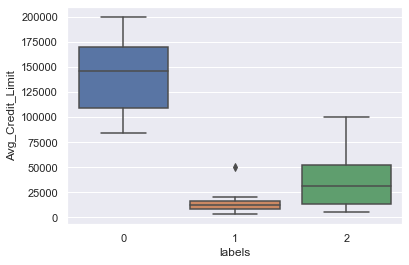

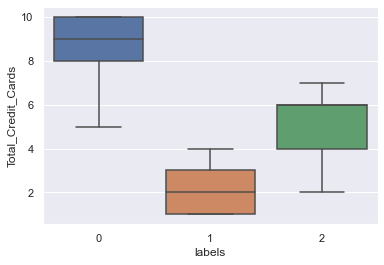

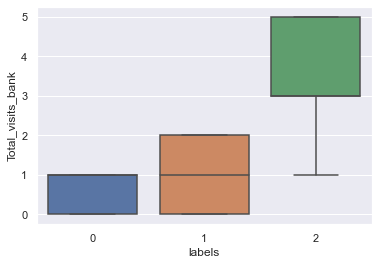

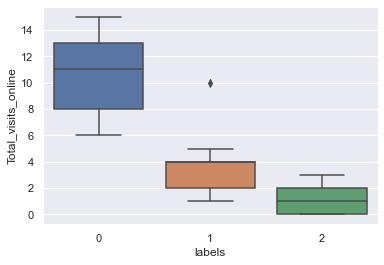

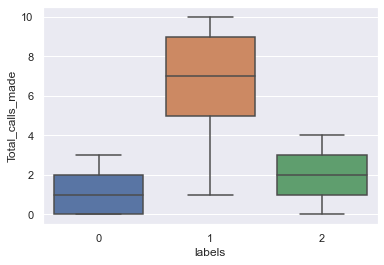

In [17]:
for i in range(5):
    sns.boxplot(y=bank2_labelled.iloc[:,i],x=bank2_labelled.iloc[:,5])
    plt.show()

In [18]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0, 'Phone Calls')

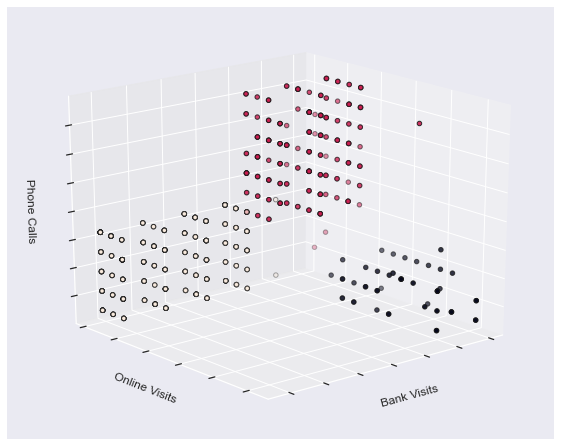

In [19]:
fig=plt.figure(figsize=(8,6))
ax=Axes3D(fig,rect=[0,0,0.95,1],elev=20,azim=50)
labels=kmeans.labels_
ax.scatter(bank2_z.iloc[:,2],bank2_z.iloc[:,3],bank2_z.iloc[:,4],c=labels.astype(np.float),edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Bank Visits')
ax.set_ylabel('Online Visits')
ax.set_zlabel('Phone Calls')

We can see very clear clusters in the 3D space. they are tagged black, red and yellow and occupy a fairly differentiated space

In [20]:
bank3=bank.drop(columns=['Sl_No','Customer Key'],axis=1)

In [21]:
bank3_z = bank3.apply(zscore)

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from scipy.spatial.distance import pdist
z=linkage(bank3_z, method='ward', metric='euclidean')
c,coph_dists= cophenet(z,pdist(bank3_z))
print(z.shape)
print(c)

(659, 4)
0.7415156284827493


In [23]:
z[:]

array([[ 464.        ,  497.        ,    0.        ,    2.        ],
       [ 425.        ,  455.        ,    0.        ,    2.        ],
       [ 250.        ,  361.        ,    0.        ,    2.        ],
       ...,
       [1313.        , 1314.        ,   16.84480374,  385.        ],
       [1311.        , 1316.        ,   47.06715339,  435.        ],
       [1315.        , 1317.        ,   50.16298666,  660.        ]])

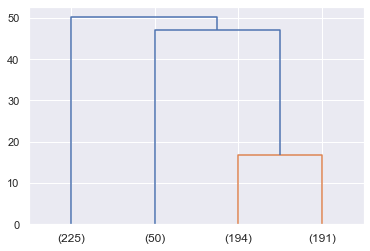

In [24]:
dendrogram(
    z,
    truncate_mode='lastp',
    p=4
)
plt.show()

The dendrogram also shows three primary clusters, The next one is little bit distance away.

In [25]:
max_d=40
from scipy.cluster.hierarchy import fcluster
clusters1 = fcluster(z, max_d,criterion='distance')
clusters1

array([3, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [26]:
from sklearn.metrics import silhouette_score
silhouette_score(bank3_z,clusters1)

0.5147639589977819

In [27]:
silhouette_score(bank3_z,df_labels)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5157182558881063

the k-means is performaing slightly better than the hierachical

In [28]:
z=linkage(bank3_z, method='average', metric='mahalanobis')
c,coph_dists= cophenet(z,pdist(bank3_z))
print(z.shape)
print(c)

(659, 4)
0.8326994115042134


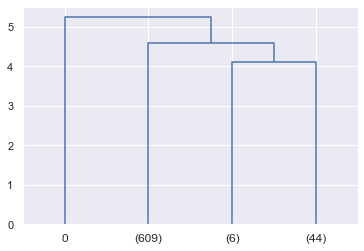

In [29]:
dendrogram(
    z,
    truncate_mode='lastp',
    p=4
)
plt.show()

In [30]:
max_d=4
clusters2 = fcluster(z, max_d,criterion='distance')
clusters2

array([4, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

this clustering shows a better cophenet score but the overall clustering done was partial. i.e. only a few members separated. Also the silhouette scores are now worse. I am sure if silhouette scores relate only to  k-means or also can compare between k-means and hierarchical

In [31]:
bankclust=pd.DataFrame(clusters1,columns=list(['labels']))
bank3_labelled = bank3.join(bankclust)
bank3_labelled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,3
1,50000,3,0,10,9,1
2,50000,7,1,3,4,3
3,30000,5,1,1,4,3
4,100000,6,0,12,3,2


In [32]:
bank3_labelled['labels'].value_counts()

3    385
1    225
2     50
Name: labels, dtype: int64

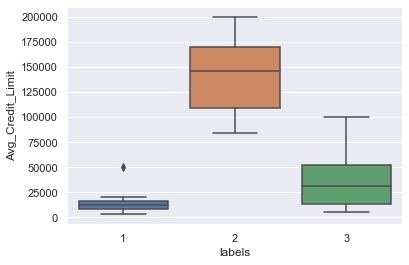

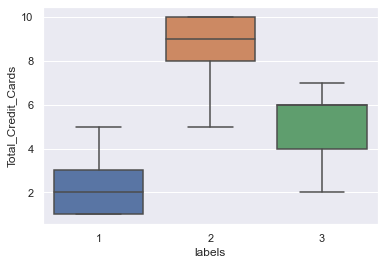

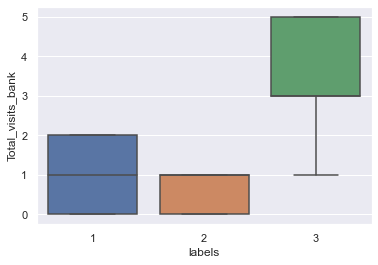

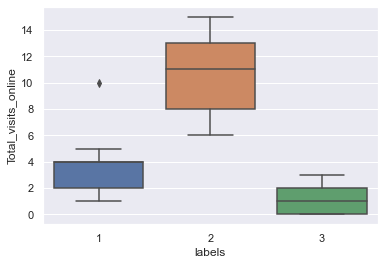

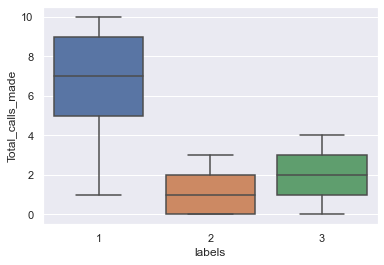

In [33]:
for i in range(5):
    sns.boxplot(y=bank2_labelled.iloc[:,i],x=bank3_labelled.iloc[:,5])
    plt.show()

Text(0.5, 0, 'Phone Calls')

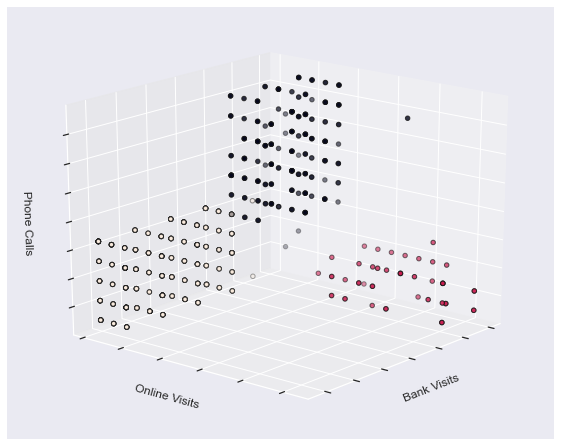

In [43]:
fig=plt.figure(figsize=(8,6))
ax=Axes3D(fig,rect=[0,0,0.95,1],elev=20,azim=40)

ax.scatter(bank3_z.iloc[:,2],bank3_z.iloc[:,3],bank3_z.iloc[:,4],c=clusters1.astype(np.float),edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Bank Visits')
ax.set_ylabel('Online Visits')
ax.set_zlabel('Phone Calls')

Text(0.5, 0, 'Phone Calls')

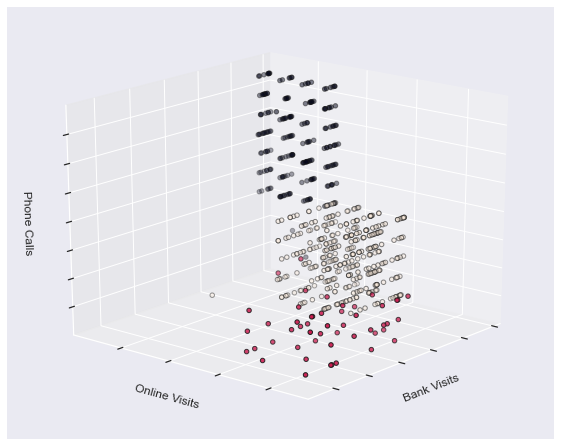

In [44]:
fig=plt.figure(figsize=(8,6))
ax=Axes3D(fig,rect=[0,0,0.95,1],elev=20,azim=40)

ax.scatter(bank3_z.iloc[:,0],bank3_z.iloc[:,1],bank3_z.iloc[:,4],c=clusters1.astype(np.float),edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Credit Limit')
ax.set_ylabel('Credit Cards')
ax.set_zlabel('Phone Calls')

Similar cluster 3D chart to k-means clustering, we will use the k-means cluster label data for further analyses

In [35]:
bank2_z_labelled = bank2_z.join(df_labels)

In [36]:
#Now lets examine high value segment (cluster 2) vs. low value segment (cluster 1)
high_segment = bank2_z_labelled[bank2_z_labelled['labels']==2]
low_segment = bank2_z_labelled[bank2_z_labelled['labels']==1]

In [37]:
high_segment.drop(columns=['labels'],inplace=True)
high_segment.head()

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.54749,-1.251537
2,0.410293,1.058973,-0.860451,0.13429,0.145528
3,-0.121665,0.135694,-0.860451,-0.54749,0.145528
228,-0.653623,1.058973,-0.247170,-0.88838,-1.251537
229,-0.706819,1.058973,-0.247170,-0.54749,0.145528


In [38]:
low_segment.drop(columns=['labels'],inplace=True)
low_segment.head()

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326


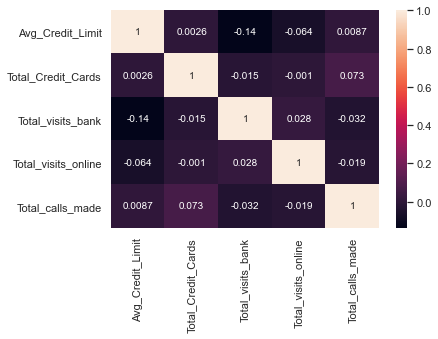

In [39]:
corr = high_segment.corr()
sns.heatmap(corr,annot=True);

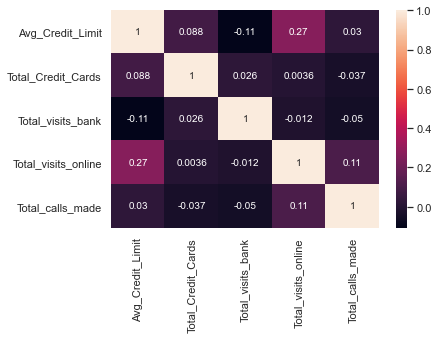

In [40]:
corr = low_segment.corr()
sns.heatmap(corr,annot=True);

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


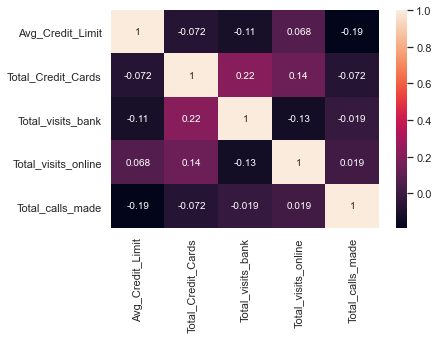

In [41]:
mid_segment = bank2_z_labelled[bank2_z_labelled['labels']==0]
mid_segment.drop(columns=['labels'],inplace=True)
corr = mid_segment.corr()
sns.heatmap(corr,annot=True);

When we looked at the original heatmap, we could easily say that phone calls have a negative relationship with Total credit cards, but now we can see it has no impact for three segments.

lets address the business problem: Which is to increase the credit cards to new users and upsell current users
1. For upselling,i.e. increased credit limit and increased number of cards, online visit seems to be a service area of high engagement. The cluster to focus are low and mid clusters. 
2. Mid cluster likes bank visits as well for their engagement. For their needs at their level of engagement, more online improvement of service breadth and depth can be introduced.
3. Phone calls seem to be offering no correlation to credit cards or credit limit in all segment. Its best to focus the resources in this service delivery channel to new customers

In [45]:
!jupyter nbconvert  "BankCluster.ipynb" --to html

[NbConvertApp] Converting notebook BankCluster.ipynb to html
[NbConvertApp] Writing 1109489 bytes to BankCluster.html
